## Test

In [1]:
from dcapy.schedule import Well, WellsGroup, Period, Scenario
from dcapy import dca
from dcapy.wiener import MeanReversion
from dcapy.cashflow import CashFlowParams
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rv_histogram

In [2]:
oil_mr = MeanReversion(
    initial_condition = 66,
    ti = 0,
    generator = {'dist':'norm','kw':{'loc':0,'scale':3}},
    m=50,
    steps=36,
    eta=0.112652,
    freq_input = 'M'
)

In [3]:
cp = CashFlowParams(**{
          'name':'Income',
          'value':dca.ProbVar(dist='uniform',kw={'loc':30,'scale':35}),
          'multiply': 'oil_volume',
          'target':'income',
          'wi':0.92
      })
cp.get_value(5,freq_output='M',seed=21)

array([31.70537083])

In [4]:
prob_prod = dca.ProbVar(dist='triang',kw={'c':0.2,'loc':15,'scale':35})
prob_oil_price = dca.ProbVar(dist='uniform',kw={'loc':30,'scale':35})

prod_rand = prob_prod.get_sample(20)
price_rand = prob_oil_price.get_sample(20)   

/home/scuervo91/anaconda3/envs/dcapy/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

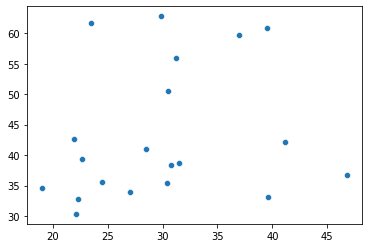

In [5]:
sns.scatterplot(prod_rand,price_rand)

In [6]:
p = Period(
    name='base',
    dca = dca.Arps(
      qi = prod_rand.tolist(),
      di = 0.005102753514909305,
      freq_di='D',
      ti = 0,
      b=1,
    ),
    start = 0,
    end=36,
    freq_output='M',
    freq_input='M',
    cashflow_params = [
      {
          'name':'wo',
          'value':-212000,
          'periods':1,
          'target':'capex'
      },
      {
          'name':'Opex',
          'value':-7,
          'multiply': 'oil_volume',
          'target':'opex'
      },
      {
          'name':'Income',
          'value':price_rand.tolist(),
          'multiply': 'oil_volume',
          'target':'income',
          'wi':0.92
      },
      {
          'name':'abandon',
          'value':-200000,
          'periods':-1,
          'target':'capex'
      },

    ]
)
s = Scenario(name='sc', periods = [p])
w = Well(
      name = f'well_eagle',
      scenarios = [
        s
      ]
)

gw = WellsGroup(name='wells',wells=[w], seed=21)
gw.tree()

🏭wells                                                                                      
┗━━ 🗼well_eagle                                                                             
    ┗━━ 🔀sc                                                                                 
        ┗━━ 📉base                                                                           

/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:84: RuntimeWarning: divide by zero encountered in true_divide
  f = qi/(di*(b-1))
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:87: RuntimeWarning: invalid value encountered in multiply
  return f*(g-h)


<AxesSubplot:xlabel='date', ylabel='oil_rate'>

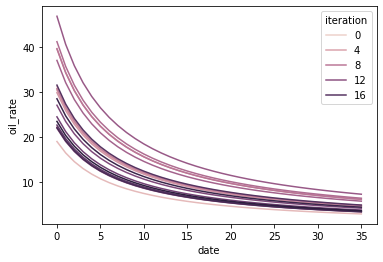

In [7]:
f = gw.generate_forecast(freq_output='M')
sns.lineplot(data=f,x=f.index, y=f.oil_rate,hue='iteration')

In [8]:
c = gw.generate_cashflow(freq_output='M')

print(len(c))

20


In [9]:
npv_df = gw.npv(0.15,freq_cashflow='M')/1000
npv_df['rate'] = prod_rand
npv_df['price'] = price_rand
npv_df['npv_b'] = npv_df['npv'].apply(lambda x: 1 if x>0 else 0)

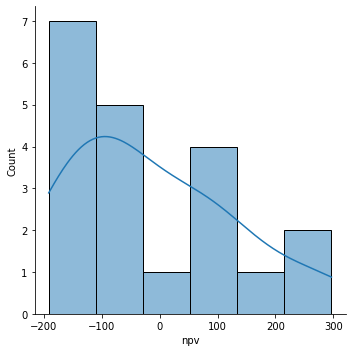

In [10]:
sns.displot(npv_df['npv'], kde=True)

<AxesSubplot:xlabel='npv', ylabel='Proportion'>

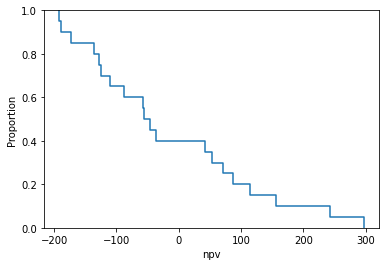

In [12]:
npv_dist = rv_histogram(np.histogram(npv_df['npv'], bins=100))
sns.ecdfplot(data=npv_df, x="npv", complementary=True)

In [13]:
npv_dist = rv_histogram(np.histogram(npv_df['npv'], bins=100))

In [14]:
npv_dist.sf(0)

0.39999999999999913

<AxesSubplot:xlabel='rate', ylabel='price'>

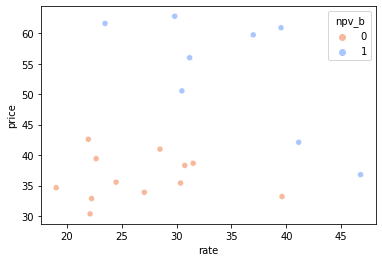

In [15]:
sns.scatterplot(data=npv_df, x="rate", y="price", hue='npv_b',palette='coolwarm_r')

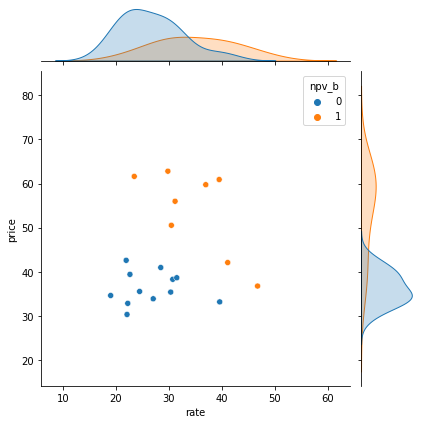

In [16]:
sns.jointplot(data=npv_df, x="rate", y="price",hue='npv_b')

## Group Wells

In [17]:
list_wells = ['DIJAR-3','DIJAR-4','DIJAR-8','DIJAR-1-1']
initial_time = np.arange(len(list_wells))
capex = [-212000,-276000,-385000,-212000]
list_wells_sched=[]

prod_eagle = prob_prod.get_sample(1000)
price_eagle = prob_oil_price.get_sample(1000)   

for i, well in enumerate(list_wells):

    p = Period(
        name='base',
        dca = dca.Arps(
        qi = prod_eagle.tolist(),
        di = 0.005102753514909305/5,
        freq_di='D',
        ti = initial_time[i],
        b=1,
        ),
        start = 0,
        end=36,
        freq_output='M',
        freq_input='M',
        cashflow_params = [
        {
            'name':'wo',
            'value':capex[i],
            'periods':1,
            'target':'capex'
        },
        {
            'name':'Opex',
            'value':-7,
            'multiply': 'oil_volume',
            'target':'opex'
        },
        {
            'name':'Income',
            'value':price_eagle.tolist(),
            'multiply': 'oil_volume',
            'target':'income',
            'wi':0.92
        },
        {
            'name':'abandon',
            'value':-200000,
            'periods':-1,
            'target':'capex'
        },

        ]
    )
    s = Scenario(name='sc', periods = [p])
    w = Well(
        name = list_wells[i],
        scenarios = [
            s
        ]
    )
    list_wells_sched.append(w)

eagle_wells = WellsGroup(name='eagle',wells=list_wells_sched)
eagle_wells.tree()

🏭eagle                                                                                      
┣━━ 🗼DIJAR-3                                                                                
┃   ┗━━ 🔀sc                                                                                 
┃       ┗━━ 📉base                                                                           
┣━━ 🗼DIJAR-4                                                                                
┃   ┗━━ 🔀sc                                                                                 
┃       ┗━━ 📉base                                                                           
┣━━ 🗼DIJAR-8                                                                                
┃   ┗━━ 🔀sc                                                                                 
┃       ┗━━ 📉base                                                                           
┗━━ 🗼DIJAR-1-1                                                                              
    ┗━━ 🔀sc                                                                                 
        ┗━━ 📉base                                                                           

In [18]:
f = eagle_wells.generate_forecast(freq_output='M')
c = eagle_wells.generate_cashflow(freq_output='M')
print(len(c))

/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:84: RuntimeWarning: divide by zero encountered in true_divide
  f = qi/(di*(b-1))
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:87: RuntimeWarning: invalid value encountered in multiply
  return f*(g-h)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:84: RuntimeWarning: divide by zero encountered in true_divide
  f = qi/(di*(b-1))
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:87: RuntimeWarning: invalid value encountered in multiply
  return f*(g-h)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:84: RuntimeWarning: divide by zero encountered in true_divide
  f = qi/(di*(b-1))
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:87: RuntimeWarning: invalid value encountered in multiply
  return f*(g-h)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:84: RuntimeWarning: divide by zero encountered in true_divide
  f = qi/(di*(b-1))
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:87: RuntimeWarning: invalid value encountered in multip

1000


<AxesSubplot:xlabel='date', ylabel='oil_cum'>

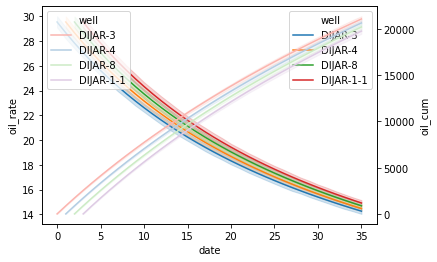

In [19]:
fig, ax = plt.subplots()

sns.lineplot(data=f, x='date', y='oil_rate',hue='well', ax=ax)
ax2 = ax.twinx()
sns.lineplot(data=f, x='date', y='oil_cum', hue='well',ax=ax2, palette='Pastel1')

<ipython-input-20-c1bfeafc83c7>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_prod = f.reset_index().groupby(['date','iteration'])['oil_rate','oil_cum'].sum().reset_index()


<AxesSubplot:xlabel='date', ylabel='oil_cum'>

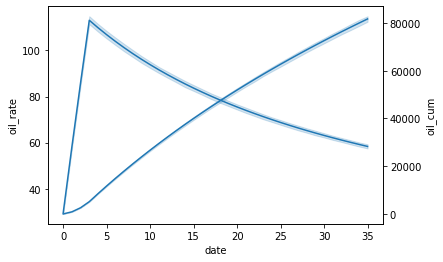

In [20]:
fig, ax = plt.subplots()

total_prod = f.reset_index().groupby(['date','iteration'])['oil_rate','oil_cum'].sum().reset_index()
total_prod.head()


sns.lineplot(data=total_prod, x='date', y='oil_rate', ax=ax)
ax2 = ax.twinx()
sns.lineplot(data=total_prod, x='date', y='oil_cum', ax=ax2, palette='Pastel1')

In [21]:
npv_eagle = eagle_wells.npv(0.15,freq_cashflow='M')/1000
npv_eagle['rate'] = prod_eagle
npv_eagle['price'] = price_eagle
npv_eagle['npv_b'] = npv_eagle['npv'].apply(lambda x: 1 if x>0 else 0)

<AxesSubplot:xlabel='rate', ylabel='price'>

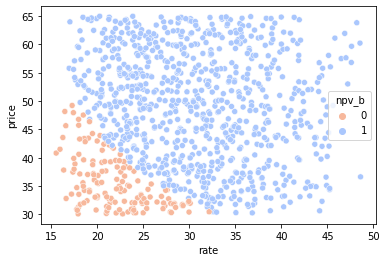

In [22]:
sns.scatterplot(data=npv_eagle, x="rate", y="price", hue='npv_b',palette='coolwarm_r')

Prob success 0.8511494421259167


<AxesSubplot:xlabel='npv', ylabel='Proportion'>

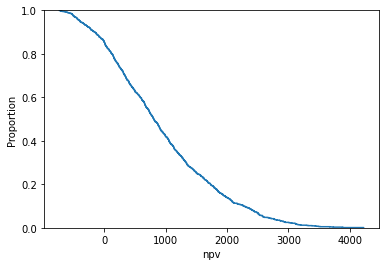

In [23]:
npv_eagle_dist = rv_histogram(np.histogram(npv_eagle['npv'], bins=100))
print(f'Prob success {npv_eagle_dist.sf(0)}')
sns.ecdfplot(data=npv_eagle, x="npv", complementary=True)